In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

In [3]:
bGENPATH = Path("/home/mkk/Downloads/behavior_from_behavior/")
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR2/")
def load_genbehavior(path, temp):
    filepath = path.joinpath(f"temperature={temp}.csv")
    x = np.loadtxt(filepath, skiprows=1, delimiter=",")
    bangle, dist, dt, state = x.T
    return bangle, dt, dist, (state-1).astype(np.int_)    
    
def load_behavior(path, temp):
    file = h5py.File(path, "r")
    grp = file[f"behaviour/{temp}"]
    bangle = format_sequences(grp["dtheta"][()])
    dt = format_sequences(grp["displacements"][()])
    dist = format_sequences(grp["interboutintervals"][()])
    file.close()
    return bangle, dt, dist

In [4]:
def reconstruct_trajs(dthets, dists):
    """Reconstruct (x,y) trajectory from a sequencere-orientation angles.
    
    Parameters :
    ------------
    dthets : 1d array
        sequence of re-orientation angles
    dists : 1d array
        sequence of bout distance

    Return :
    --------
    x : 1d array
        reconstructed x positions
    y : 1d array
        reconstructed y positions
    """
    angles = np.cumsum(-np.deg2rad(dthets))
    dxy =  dists[:,np.newaxis] * np.c_[np.cos(angles), np.sin(angles)]
    x,y = tuple(np.cumsum(dxy, axis=0).T)
    return x, y

# Figures

## Behavior from Behavior

### Distributions

In [454]:
temp = 22
BANGLEs, DTs, DISTs = load_behavior(bDATAPATH, temp)
bangle, dt, dist, state = load_genbehavior(bGENPATH, temp)

In [455]:
def hist(X, bins=None):
    h_x, b_x = np.histogram(X, bins=bins, density=True)
    h_x[h_x==0] = np.nan
    return h_x, (b_x[1:] + b_x[:-1])/2

nbins = 75

h_angles, b_angles = hist(bangle, bins=np.linspace(-180, +180, nbins))
h_ANGLES, b_ANGLES = hist(np.concatenate(BANGLEs), bins=np.linspace(-180, +180, 10*nbins))

h_dt, b_dt = hist(dt, bins=np.linspace(0, 10, nbins))
h_DT, b_DT = hist(np.concatenate(DTs), bins=np.linspace(0, 10, 10*nbins))

h_dist, b_dist = hist(dist, bins=np.linspace(0, 40, nbins))
h_DIST, b_DIST = hist(np.concatenate(DISTs), bins=np.linspace(0, 40, 10*nbins))

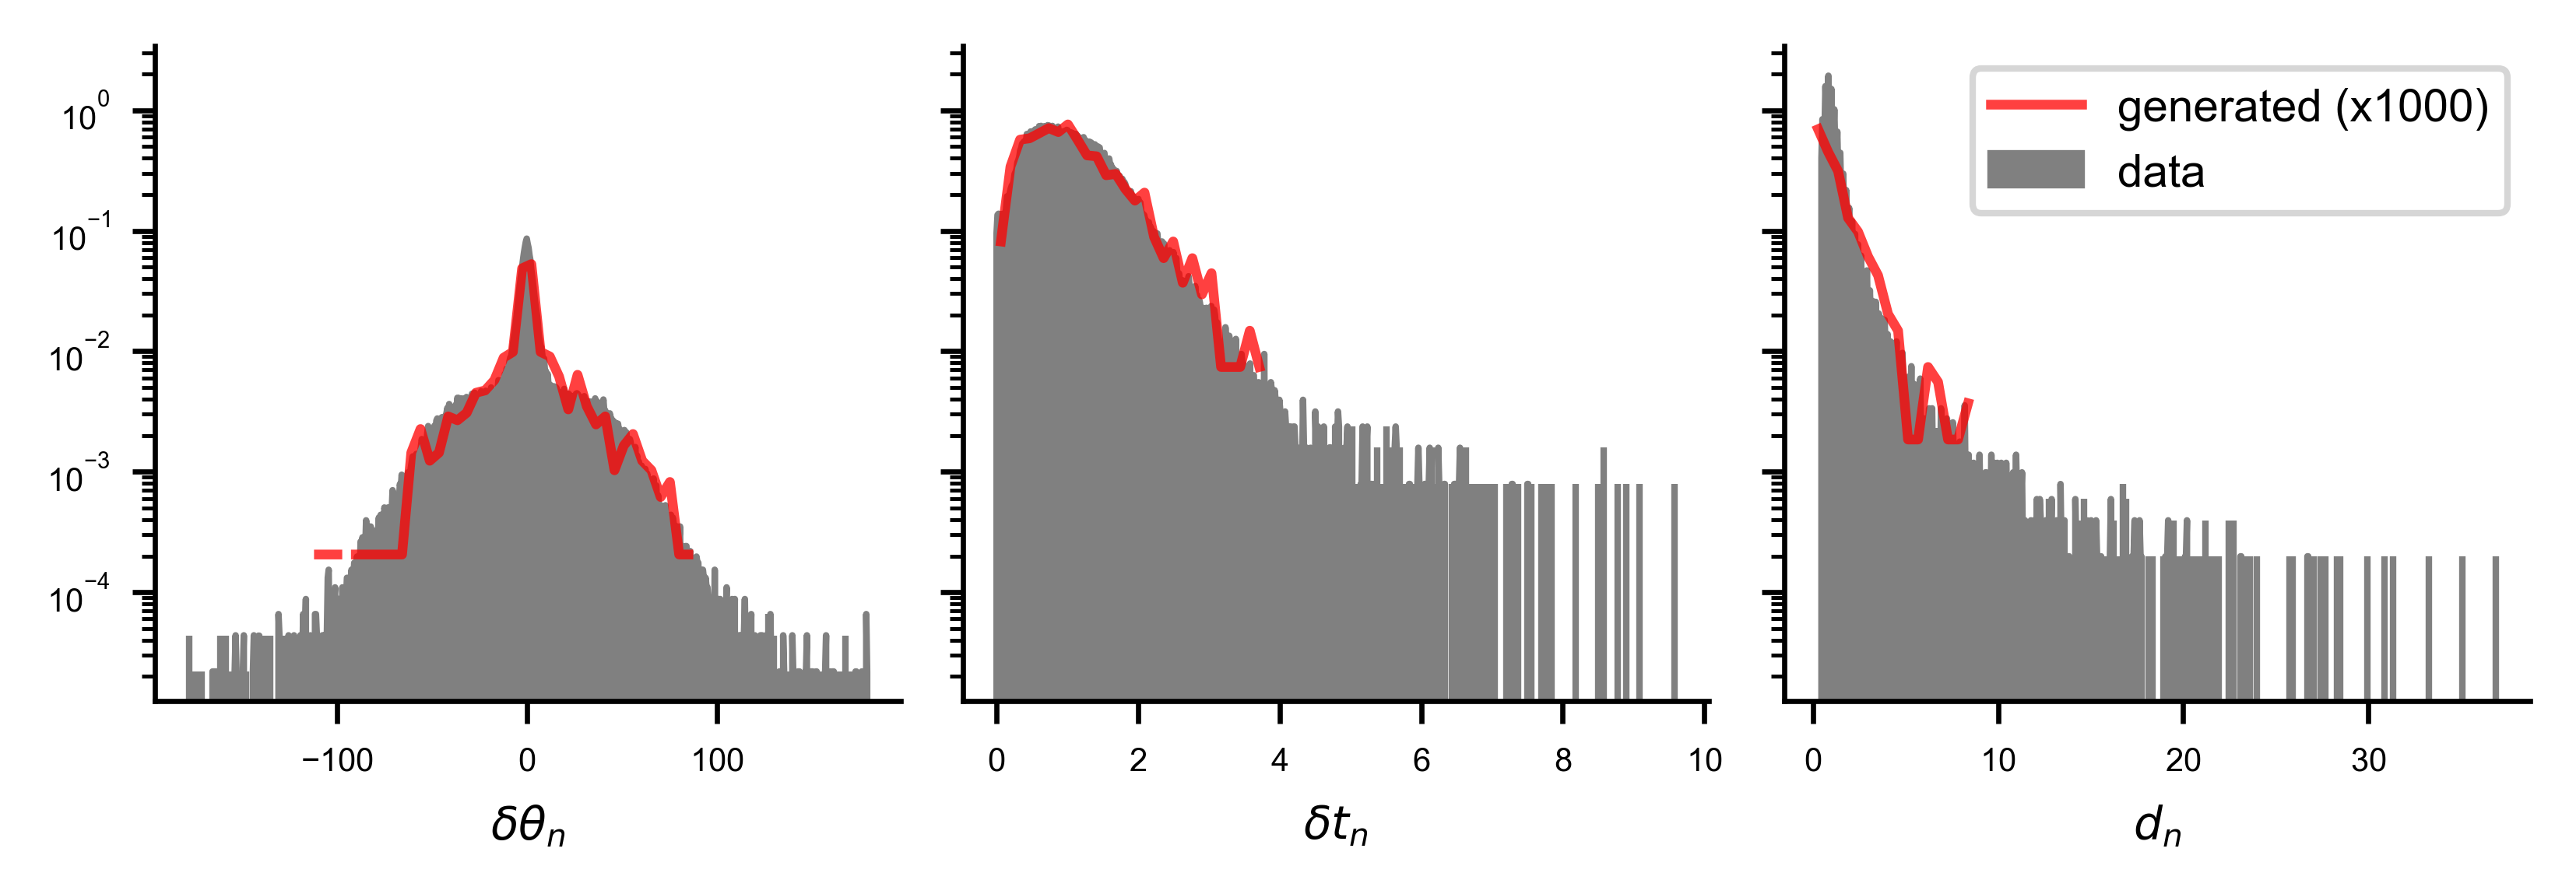

In [456]:
fig, axs = plt.subplots(ncols=3, figsize=(3*1.8,1.8), sharey=True)
for ax in axs:
    ax.set_yscale("log")

data_color = "grey"
gen_color = "r"
gen_alpha = 0.75

ax = axs[0]
ax.plot(b_angles, h_angles, color=gen_color, alpha=gen_alpha)
ax.fill_between(b_ANGLES, h_ANGLES, zorder=0, color=data_color)
ax.set_xlabel(r"$\delta\theta_n$")
#ax.set_ylabel("Density")

ax = axs[1]
ax.plot(b_dt, h_dt, color=gen_color, alpha=gen_alpha)
ax.fill_between(b_DT, h_DT, zorder=0, color=data_color)
ax.set_xlabel(r"$\delta t_n$")

ax = axs[2]
ax.plot(b_dist, h_dist, color=gen_color, alpha=gen_alpha, label="generated (x1000)")
ax.fill_between(b_DIST, h_DIST, zorder=0, color=data_color, label="data")
ax.set_xlabel(r"$d_n$")
ax.legend()

fig.savefig("panels/Fig6/BfromB_hists.svg")

### Trajectory

In [384]:
x, y = reconstruct_trajs(bangle, dist)

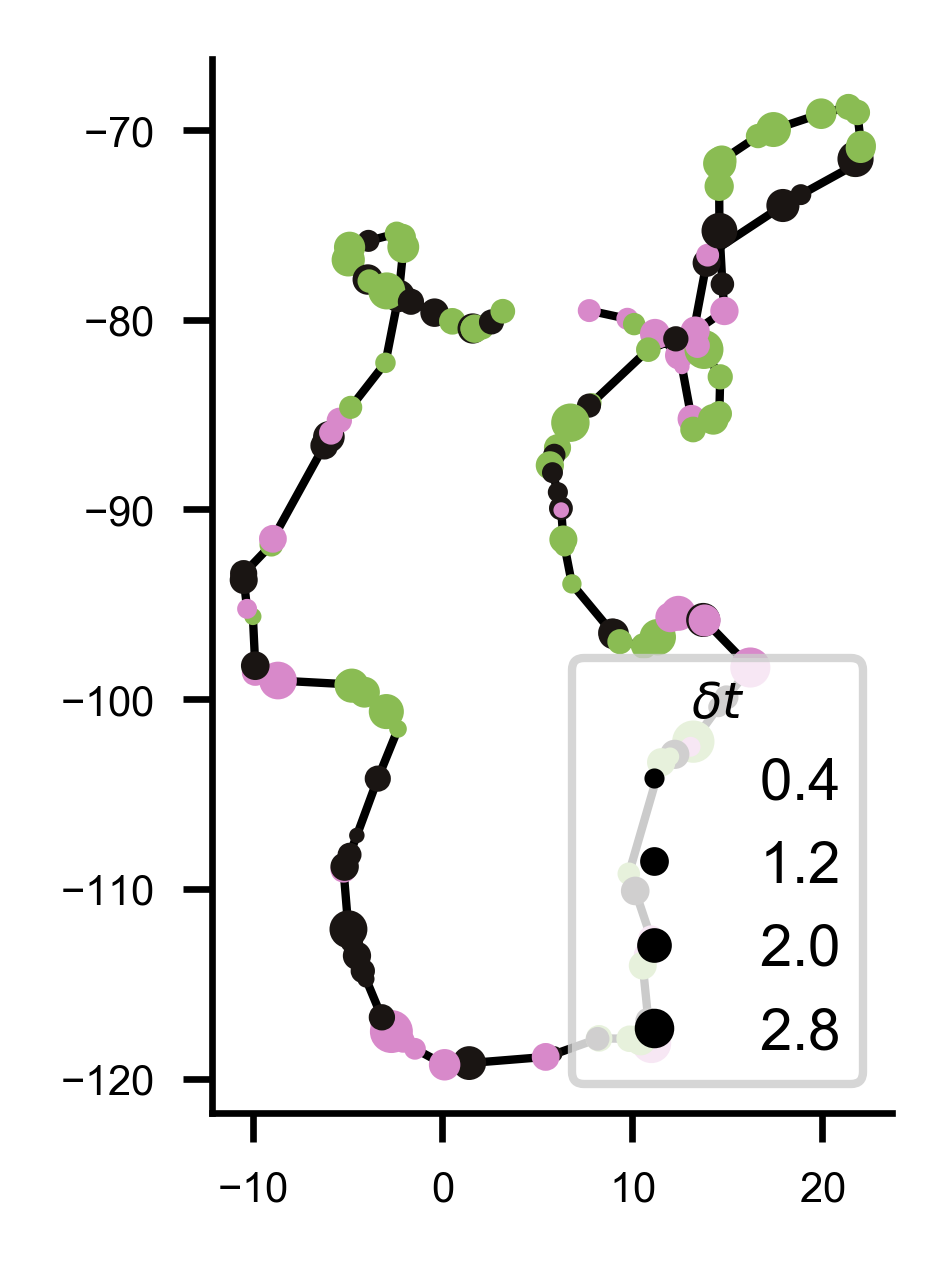

In [427]:
n1,n2 = 255,400
fig, ax = plt.subplots()
ax.plot(x[n1:n2],y[n1:n2], zorder=0, linewidth=1)
scat = ax.scatter(x[n1:n2],y[n1:n2], s=dt[n1:n2]*5, c=FLR_colors[np.insert(state[n1+1:n2], -1,0)], zorder=1)
ax.set_aspect(1)
handles, labels = scat.legend_elements(prop="sizes")
hands, labs = [], []
for h,l in zip(handles[::2], labels[::2]):
    size = int(l.split("{")[-1].split("}")[0])/5
    lab = r"$\mathdefault{"+str(size)+"}$"
    hands.append(h)
    labs.append(lab)
legnd = plt.legend(hands, labs, title=r"$\delta t$")

fig.savefig("panels/Fig6/BfromB_traj.svg")

## Behavior from Neuro

In [7]:
def load_genneuro(path, fish, temp):
    paths = sorted(nGENPATH.glob(f"temperature={temp}-fish={fish}-rep=*.csv"))
    BANGLES, DISTS, DTS, STATES = [], [], [], []
    for path in paths:
        x = np.loadtxt(path, skiprows=1, delimiter=",")
        bangle, dt, dist, state = x.T
        BANGLES.append(bangle)
        DISTS.append(dist)
        DTS.append(dt)
        STATES.append((state-1).astype(np.int_))
    return BANGLES, DISTS, DTS, STATES

In [5]:
i = 3
artr = ALL_ARTRs[i]
artr

array([11, 22])

### Distributions

In [146]:
BANGLEs, DTs, DISTs = load_behavior(bDATAPATH, artr[1])
bangle, dt, dist, state = load_genneuro(nGENPATH, *artr)

In [9]:
def hist(X, bins=None):
    h_x, b_x = np.histogram(X, bins=bins, density=True)
    h_x[h_x==0] = np.nan
    return h_x, (b_x[1:] + b_x[:-1])/2

nbins = 75

h_angles, b_angles = hist(np.concatenate(bangle), bins=np.linspace(-180, +180, nbins))
h_ANGLES, b_ANGLES = hist(np.concatenate(BANGLEs), bins=np.linspace(-180, +180, 10*nbins))

h_dt, b_dt = hist(np.concatenate(dt), bins=np.linspace(0, 10, nbins))
h_DT, b_DT = hist(np.concatenate(DTs), bins=np.linspace(0, 10, 10*nbins))

h_dist, b_dist = hist(np.concatenate(dist), bins=np.linspace(0, 40, nbins))
h_DIST, b_DIST = hist(np.concatenate(DISTs), bins=np.linspace(0, 40, 10*nbins))

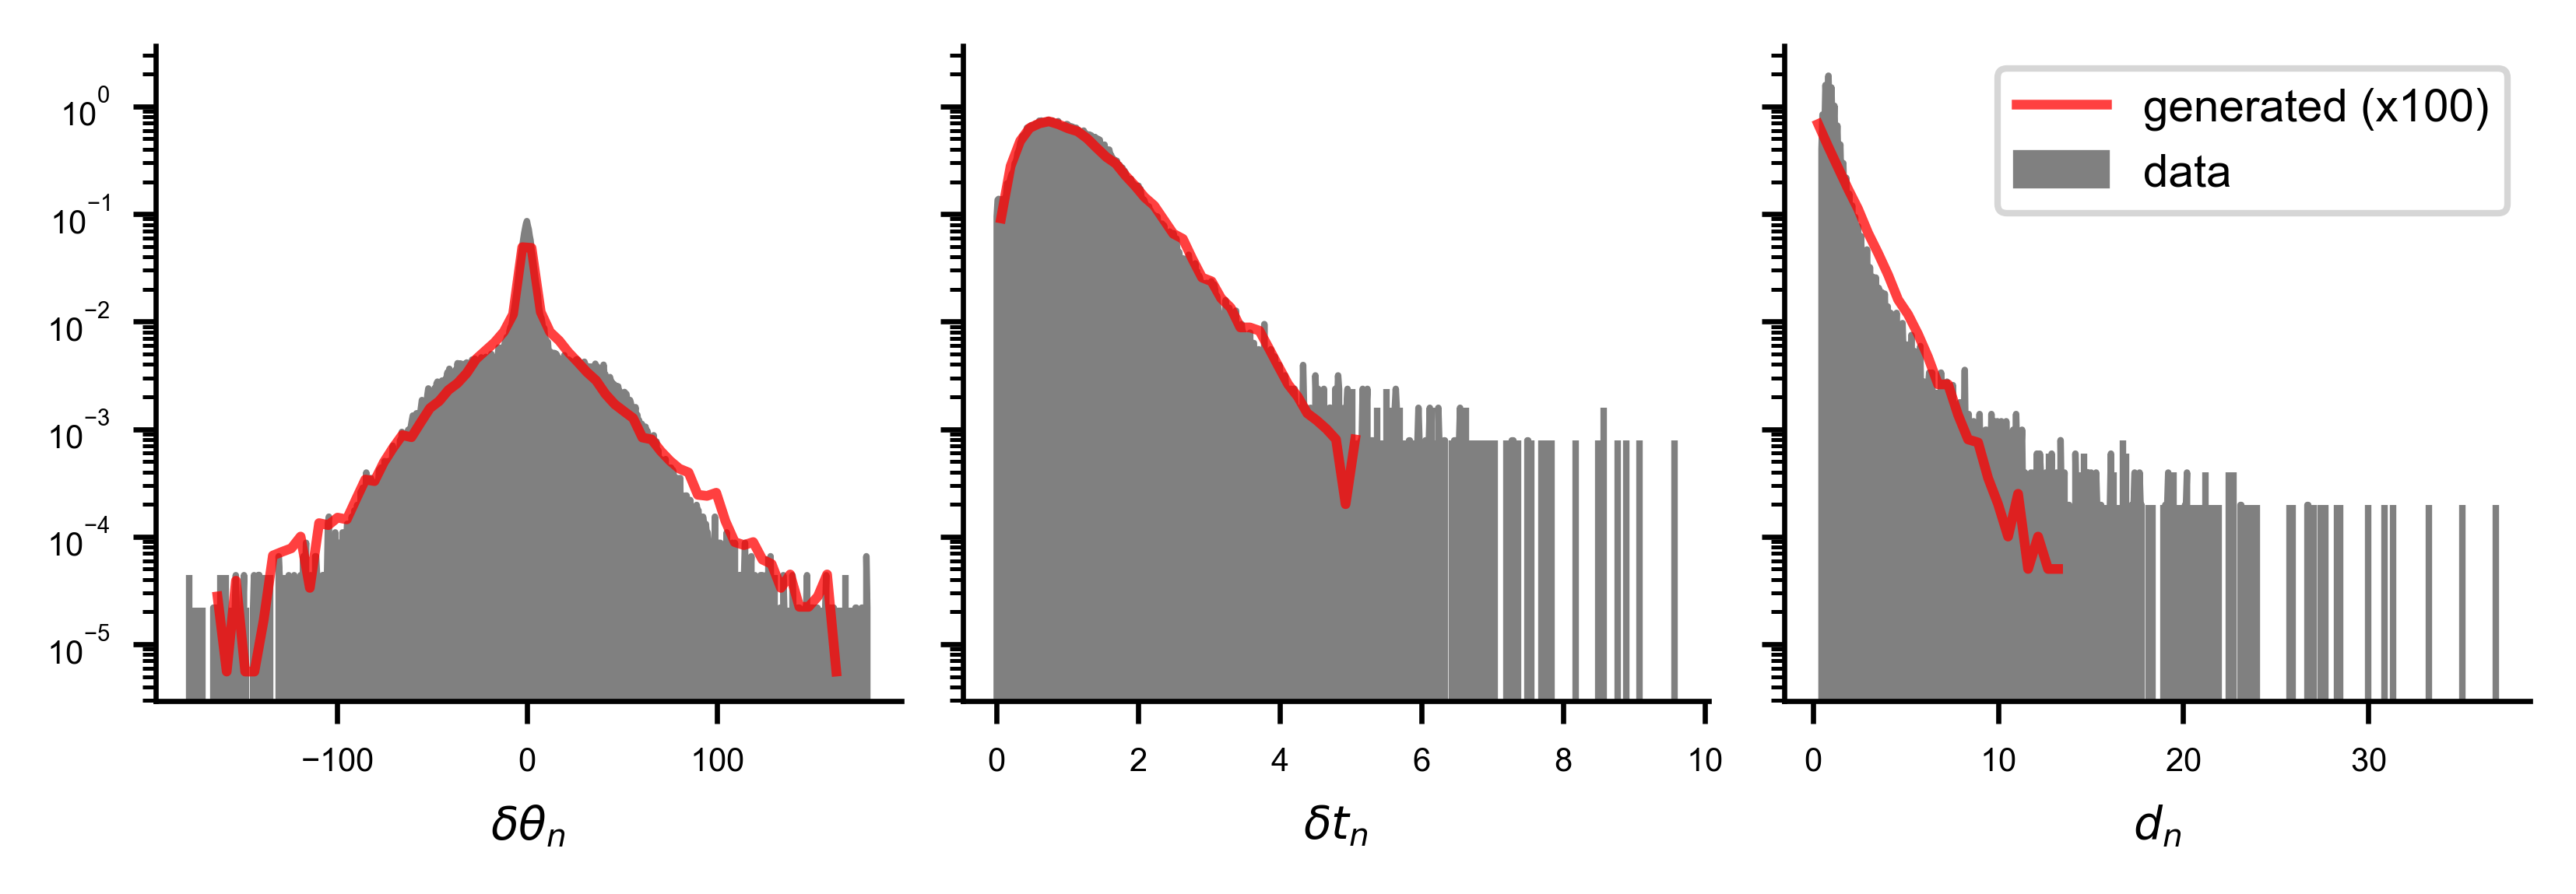

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(3*1.8,1.8), sharey=True)
for ax in axs:
    ax.set_yscale("log")

data_color = "grey"
gen_color = "r"
gen_alpha = 0.75

ax = axs[0]
ax.plot(b_angles, h_angles, color=gen_color, alpha=gen_alpha)
ax.fill_between(b_ANGLES, h_ANGLES, zorder=0, color=data_color)
ax.set_xlabel(r"$\delta\theta_n$")
#ax.set_ylabel("Density")

ax = axs[1]
ax.plot(b_dt, h_dt, color=gen_color, alpha=gen_alpha)
ax.fill_between(b_DT, h_DT, zorder=0, color=data_color)
ax.set_xlabel(r"$\delta t_n$")

ax = axs[2]
ax.plot(b_dist, h_dist, color=gen_color, alpha=gen_alpha, label="generated (x100)")
ax.fill_between(b_DIST, h_DIST, zorder=0, color=data_color, label="data")
ax.set_xlabel(r"$d_n$")
ax.legend()

fig.savefig("panels/Fig6/BfromN_hists.svg")

### all Trajectories

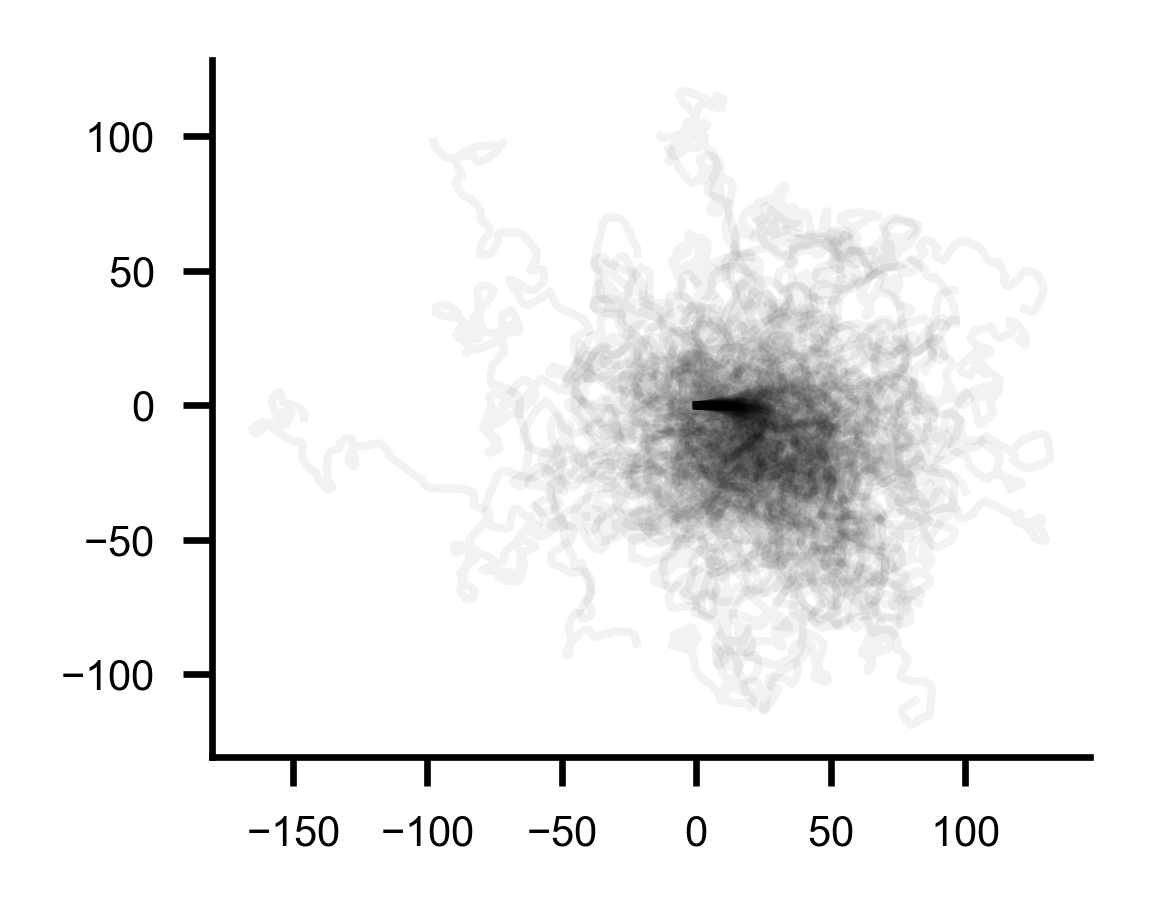

In [13]:
fig, ax = plt.subplots(figsize=(1.8,1.8))
ax.set_aspect(1)
for j in range(len(bangle)):
    x, y = reconstruct_trajs(bangle[j], dist[j])
    dtt = dt[j]
    statee = state[j]
    ax.plot(x,y, color="k", alpha=0.05, zorder=0, linewidth=1)
    #ax.scatter(x,y, s=dtt*5, c=FLR_colors[np.insert(statee[1:], -1,0)], zorder=1, alpha=0.1)

fig.savefig("panels/Fig6/BfromN_trajs.svg")

### exmaple trajectory

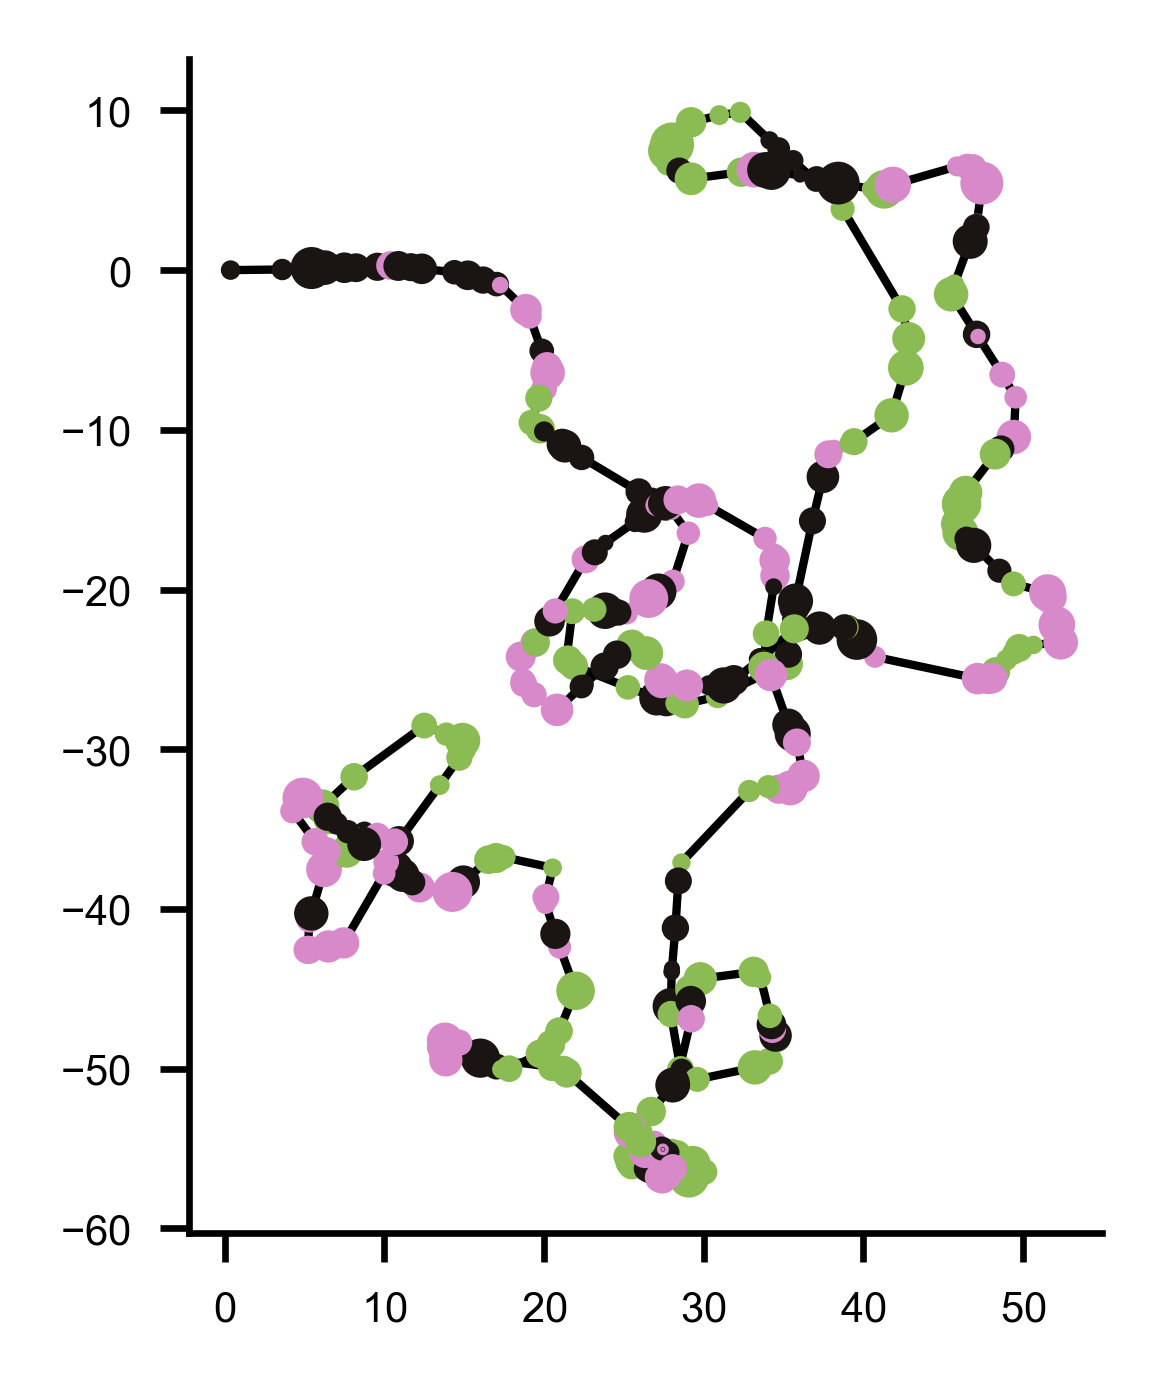

In [149]:
j = 0
x, y = reconstruct_trajs(bangle[j], dist[j])
dtt = dt[j]
statee = state[j]
fig, ax = plt.subplots(figsize=(2.2,2.2))
ax.plot(x,y, zorder=0, linewidth=1)
scat = ax.scatter(x,y, s=dtt*5, c=FLR_colors[np.insert(statee[1:], -1,0)], zorder=1)
ax.set_aspect(1)
fig.savefig("panels/Fig6/BfromN_traj.svg")

In [134]:
from matplotlib.gridspec import GridSpec
from scipy.cluster import hierarchy

In [151]:
mL, mR, L,R,dt = load_ARTR(nDATAPATH, *artr)

In [152]:
maxl = max([len(s) for s in state])
states = np.full((len(state),maxl), -1, dtype=int)
for i in range(len(state)):
    l = len(state[i])
    states[i, :l] = state[i]

In [153]:
FLRN_colors = np.vstack([FLR_colors, np.array([1,1,1,1])])

In [154]:
X = np.corrcoef(states[:,:min([len(s) for s in state])])
Z = hierarchy.ward(X)
order = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, X))

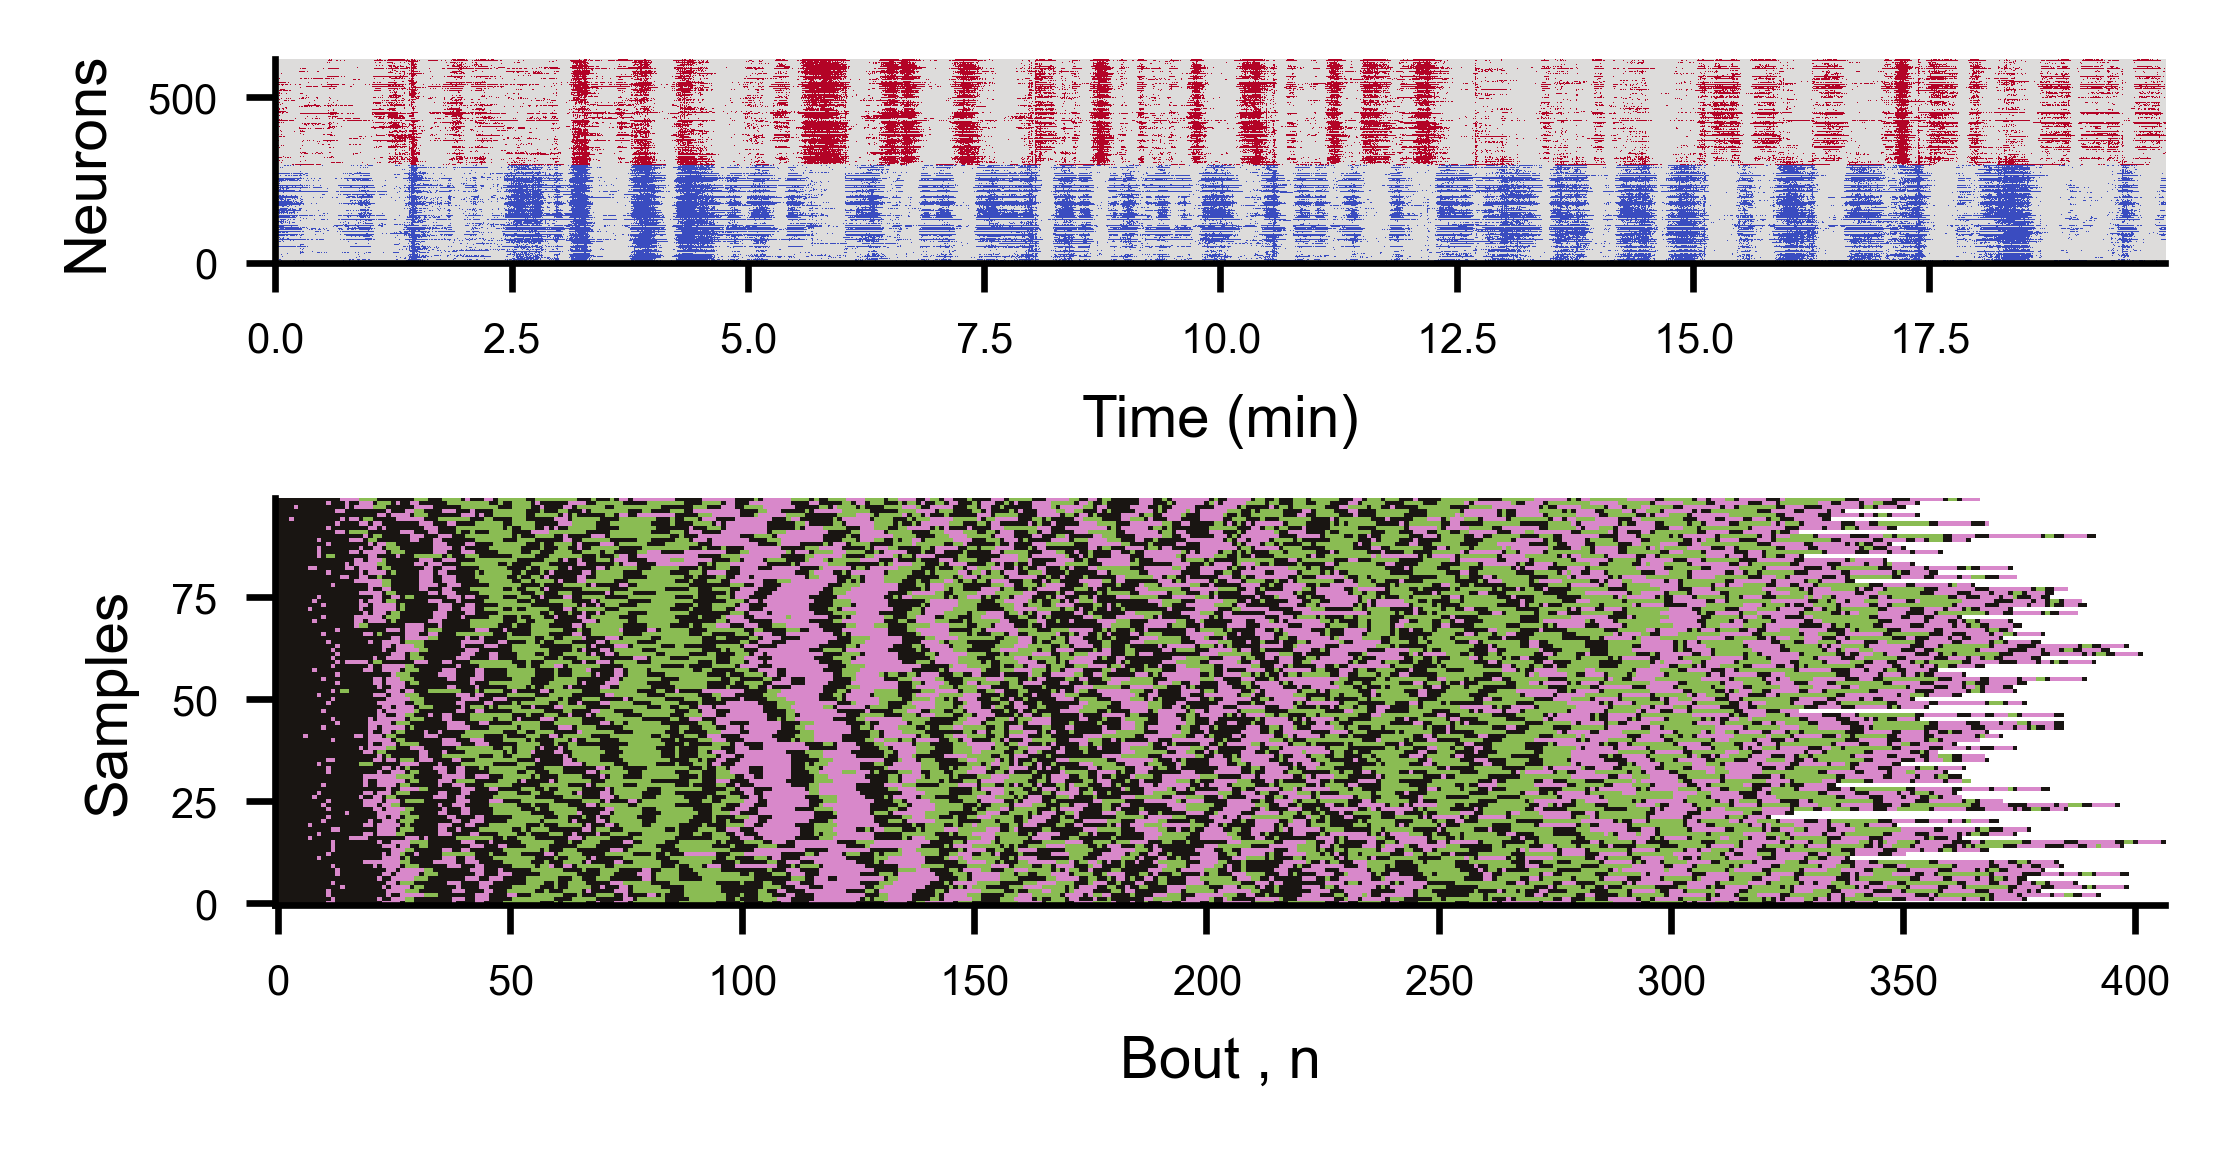

In [155]:
fig = plt.figure(figsize=(2*1.8,1.8))
gs = GridSpec(2,1,fig, height_ratios=[1/3,2/3])

ax = plt.subplot(gs[0])
t = np.arange(0,len(mL)*dt, dt)
ax.imshow(
    np.c_[-L.astype(np.int_),R.astype(np.int_)].T, 
    cmap=ARTR_CMAP, vmin=-1, vmax=+1,
    extent=(0, t[-1]/60, 0, L.shape[1] + R.shape[1]),
)
ax.set_ylabel("Neurons")
ax.set_xlabel("Time (min)")


ax = plt.subplot(gs[1])
ax.imshow(FLRN_colors[states[order,:]])
ax.set_xlabel("Bout , n")
ax.set_ylabel("Samples")

fig.savefig("panels/Fig6/BfromN_samples.svg")

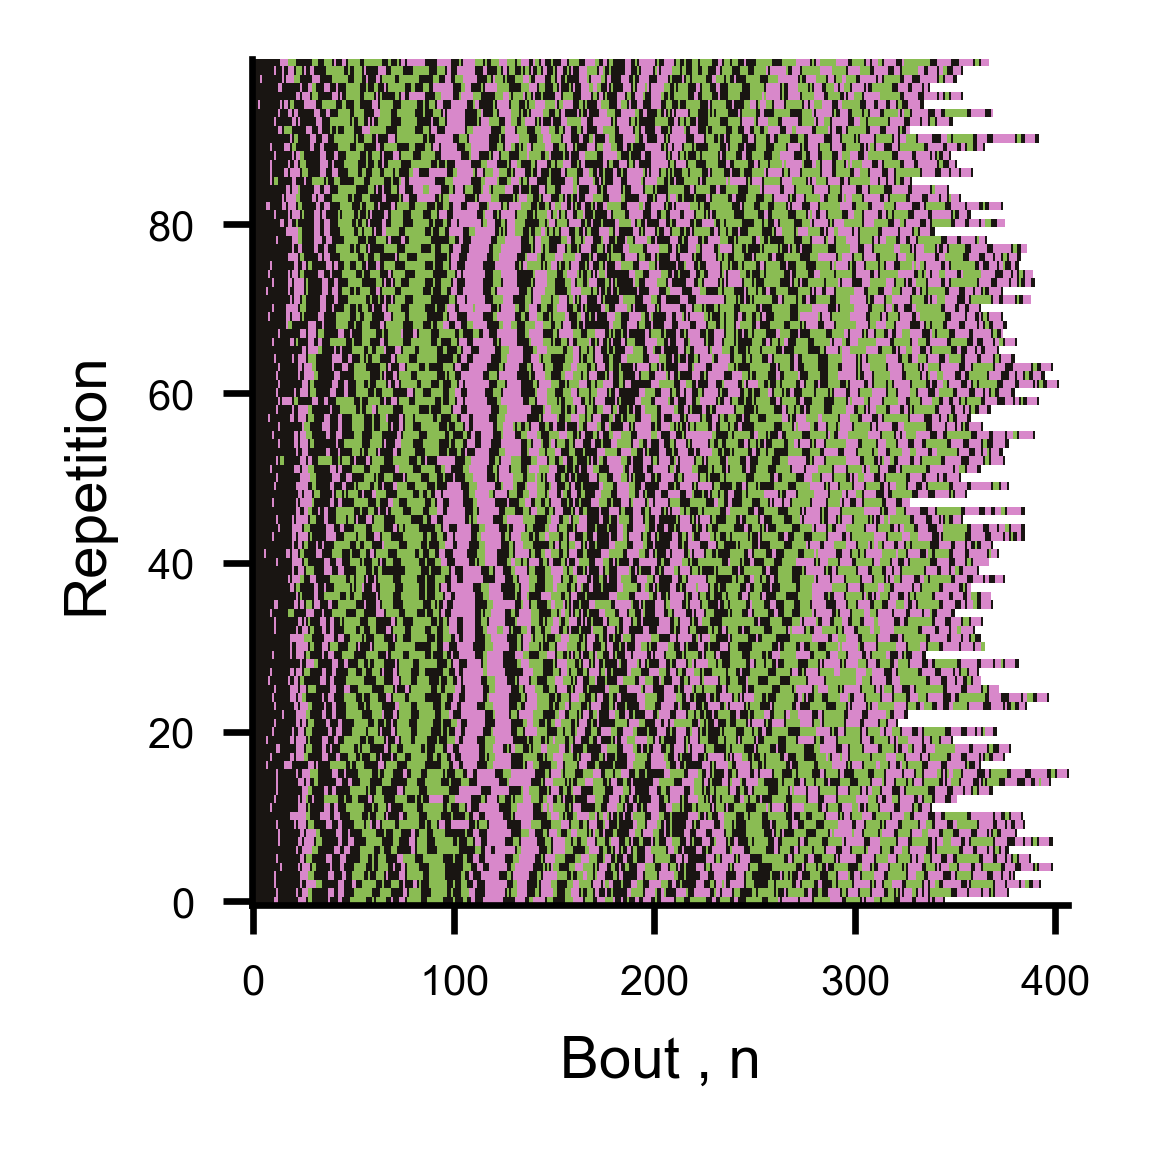

In [142]:
fig, ax = plt.subplots(figsize=(1.8,1.8))
ax.imshow(FLRN_colors[states[order,:]])
ax.set_xlabel("Bout , n")
ax.set_ylabel("Repetition")
fig.savefig("panels/Fig6/BfromN_samples.svg")

## Diagram

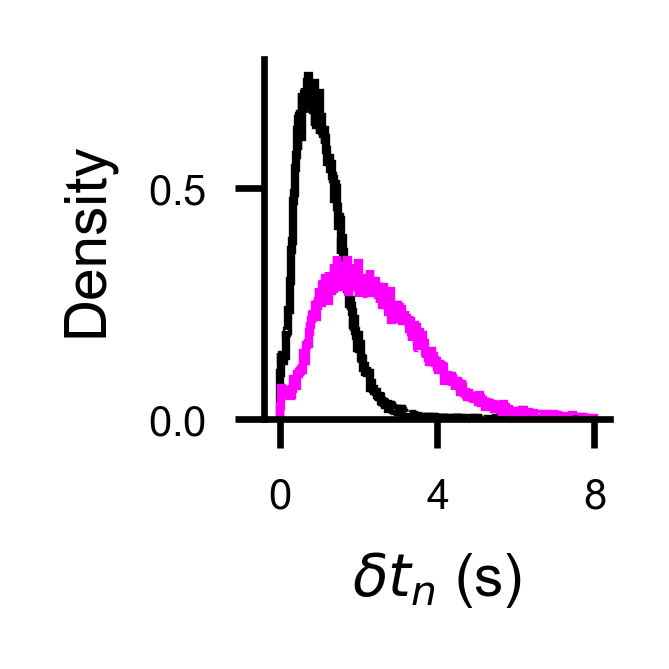

In [129]:
fig, ax = plt.subplots(figsize=(1,1))
bins = np.linspace(0, 8, 500)
ax.hist(np.concatenate(DTs), bins=bins, histtype="step", density=True, color="black");
ax.hist(np.concatenate(DTs)/0.44, bins=bins, histtype="step", density=True, color="magenta");
ax.set_xlabel(r"$\delta t_n$ (s)")
ax.set_ylabel("Density")
ax.set_xticks([0,4,8])
ax.set_yticks([0,0.5])
fig.savefig("panels/Fig6/diag_DTdistrib.svg")

In [99]:
seq_neuro = load_ARTR_viterbi(nOUTPATH, *artr)
seq_neuro_text = ",".join(np.array(["F","L","R"])[seq_neuro])

In [98]:
seq_converted = state[0]
seq_converted_text = ",".join(np.array(["F","L","R"])[seq_converted])

In [103]:
seq_neuro_text

'R,R,R,R,R,R,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,R,R,R,R,R,R,R,R,R,R,R,R,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,F,F,F,F,R,R,F,F,F,F,F,F,F,F,F,F,F,F,F,F,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,F,F,F,F,F,F,F,F,F,F,F,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,F,L,L,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F

In [128]:
dt

0.2000004050675112

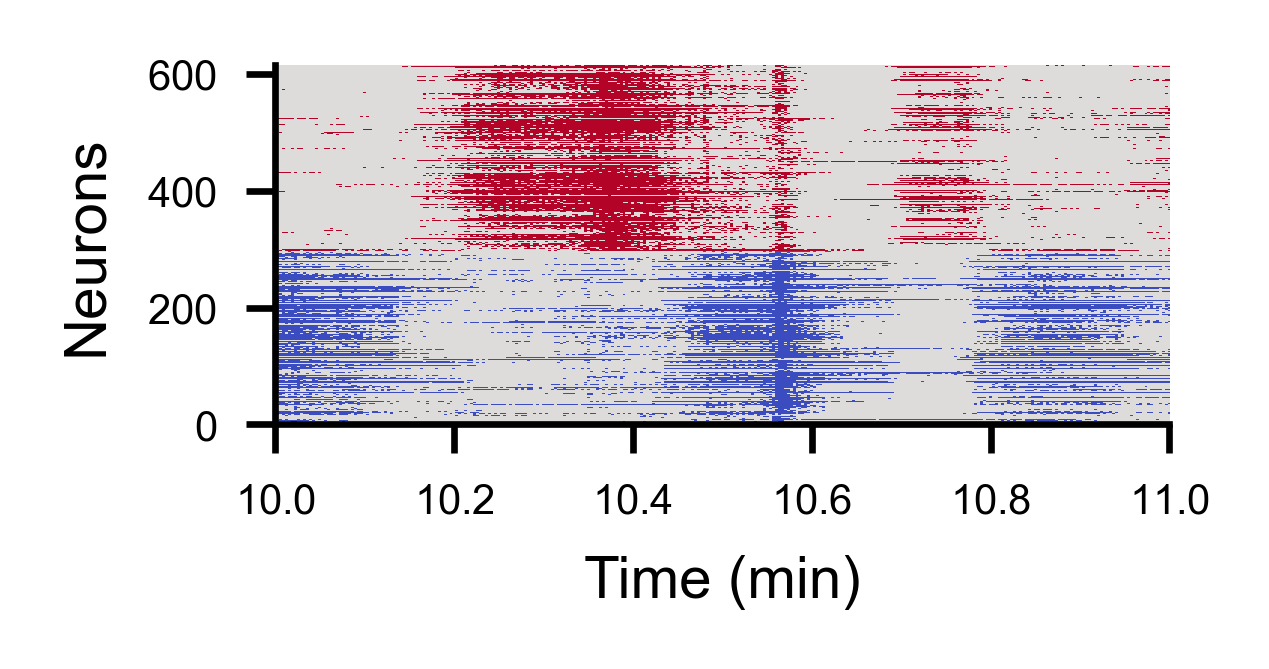

In [130]:
fig, ax = plt.subplots(nrows=1, figsize=(2,1), sharex=True)
t = np.arange(0,len(mL)*dt, dt)
ax.imshow(
    np.c_[-L.astype(np.int_),R.astype(np.int_)].T, 
    cmap=ARTR_CMAP, vmin=-1, vmax=+1,
    extent=(0, t[-1]/60, 0, L.shape[1] + R.shape[1]),
    rasterized=True,
)
ax.set_ylabel("Neurons")
ax.set_xlabel("Time (min)")

ax.set_xlim(10,11)
fig.savefig("panels/Fig6/diag_activity.svg")

In [123]:
inds = np.where((t>10*60) * (t<11*60))[0]
inds.shape

(300,)

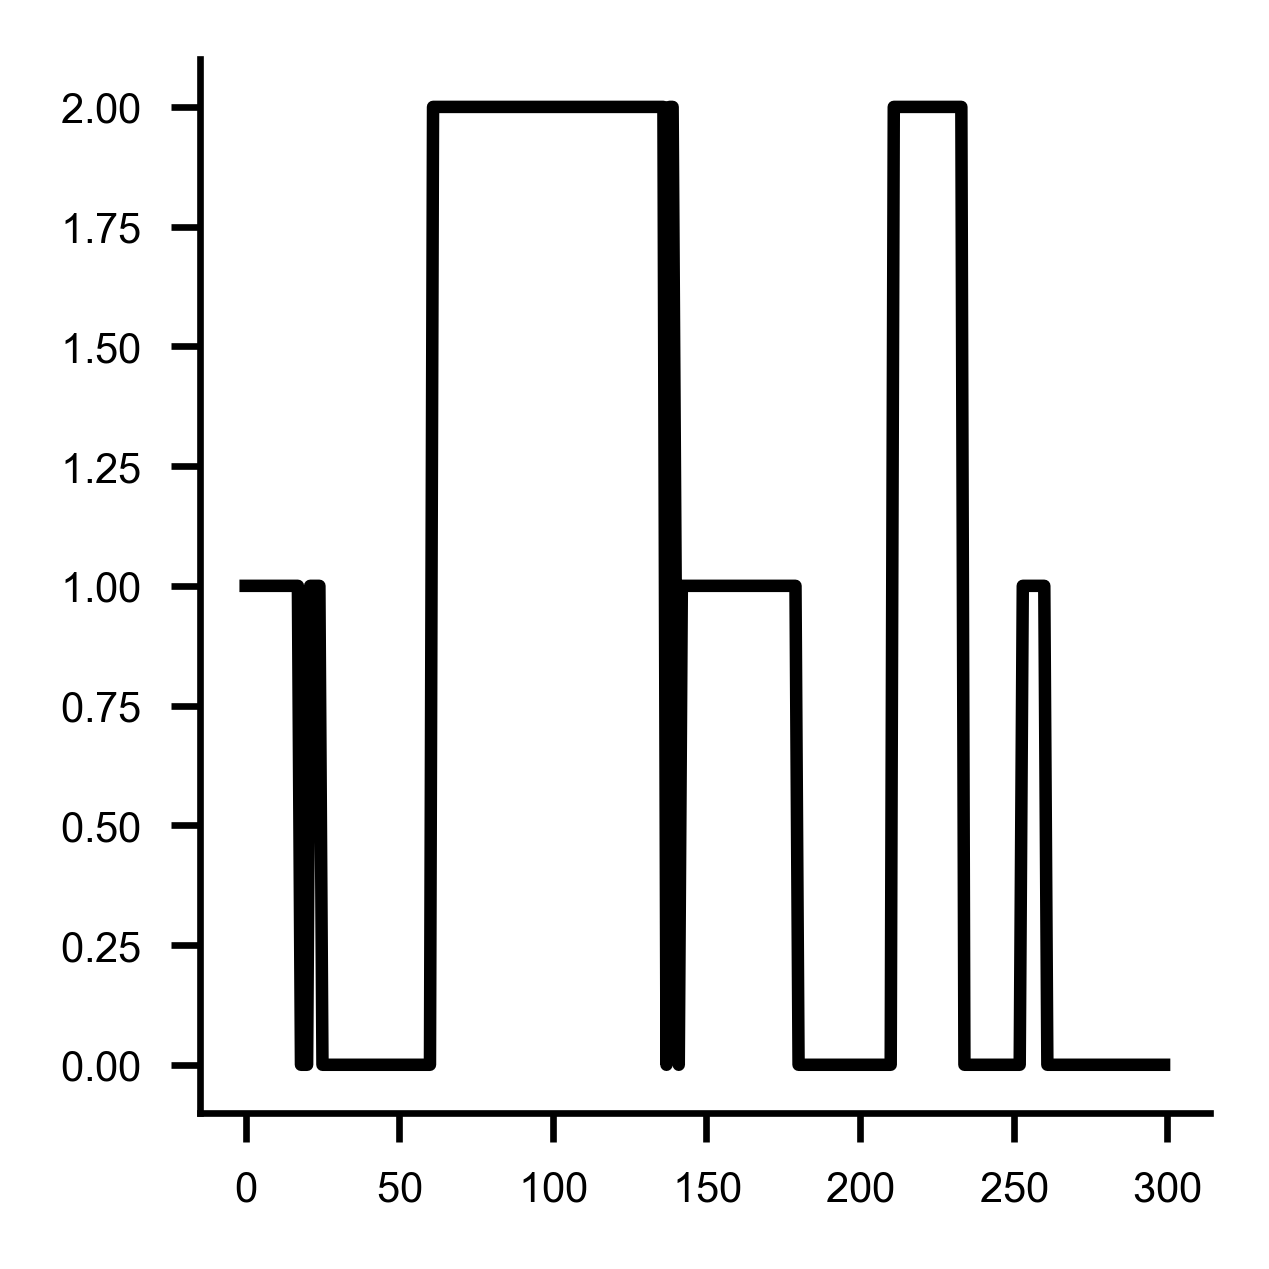

In [124]:
plt.plot(seq_neuro[inds])

In [125]:
",".join(np.array(["F","L","R"])[seq_neuro[inds]])

'L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,F,F,F,L,L,L,L,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,F,R,R,L,F,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,L,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,L,L,L,L,L,L,L,L,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F,F'

In [132]:
1/(0.2/0.44)

2.1999999999999997